<a href="https://colab.research.google.com/github/Quantzaar/Strategy/blob/main/backtest%20results/Backtest_nifty50_momentum_strategy_11_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  50 of 50 completed
[*********************100%%**********************]  1 of 1 completed


Annualized Return: 24.30%
Annualized Volatility: 18.10%
Sharpe Ratio: 1.34
Beta: 0.88
Maximum Drawdown: -26.06%


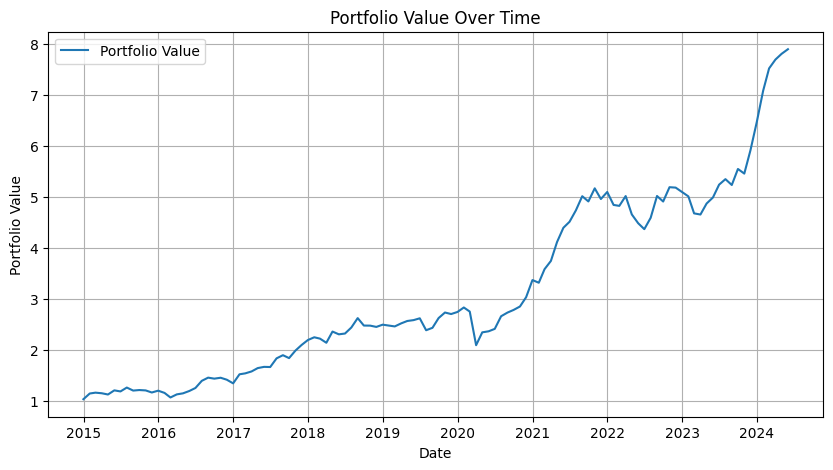

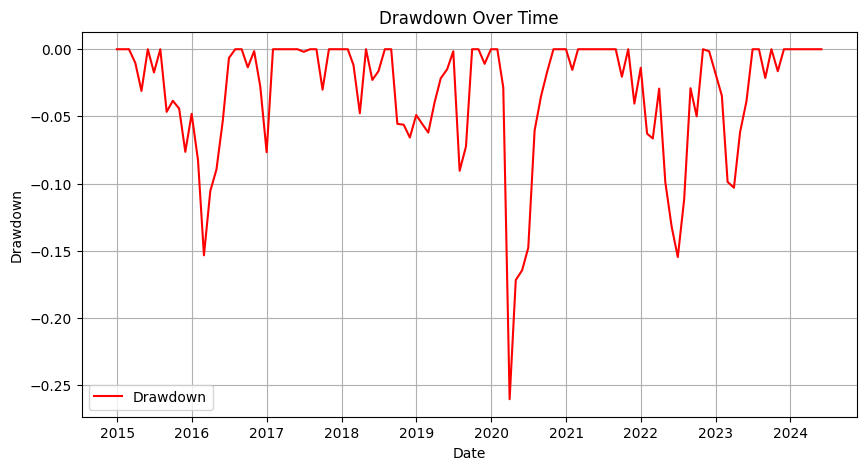

In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get NIFTY 50 stock symbols
stocks = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[2].Symbol
stocks = stocks + '.NS'

# Download historical data
df = yf.download(stocks.to_list(), start='2014-01-01')
df_close = df['Adj Close']
df_dret = df_close.pct_change()
df_mret = (df_dret + 1).resample('M').prod() - 1

# Calculate 11-month rolling returns
df_mret_11 = df_mret.rolling(11).apply(lambda x: (x + 1).prod() - 1).dropna()

# Function to calculate top performers for a given date
def top_performers(date):
    top = df_mret_11.loc[date].nlargest(10)
    port_mret = df_mret[date:][1:2][top.index].mean(axis=1).values[0]
    return port_mret

# Calculate monthly returns of the strategy
monthly_ret = []
for date in df_mret_11.index[:-1]:
    monthly_ret.append(top_performers(date))

# Calculate portfolio value over time
portfolio_value = [1]
for r in monthly_ret:
    portfolio_value.append(portfolio_value[-1] * (1 + r))

# Create a DataFrame for portfolio value
portfolio_df = pd.DataFrame({
    'Date': df_mret_11.index[1:],
    'Portfolio Value': portfolio_value[1:]
})
portfolio_df.set_index('Date', inplace=True)

# Calculate drawdown
portfolio_df['Drawdown'] = portfolio_df['Portfolio Value'] / portfolio_df['Portfolio Value'].cummax() - 1

# Calculate Sharpe ratio
annualized_return = np.prod([1 + r for r in monthly_ret]) ** (12 / len(monthly_ret)) - 1
annualized_std = np.std(monthly_ret) * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_std

# Calculate Beta
# Use NIFTY 50 index as benchmark
nifty50 = yf.download('^NSEI', start='2014-01-01')['Adj Close']
nifty50_mret = nifty50.pct_change().resample('M').apply(lambda x: (x + 1).prod() - 1).dropna()
cov_matrix = np.cov(nifty50_mret[df_mret_11.index[1]:], monthly_ret) #structure of monthly return?
beta = cov_matrix[0, 1] / cov_matrix[0, 0]

print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_std:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Beta: {beta:.2f}")
print(f"Maximum Drawdown: {portfolio_df['Drawdown'].min():.2%}")

# Plot portfolio value over time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_df['Portfolio Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot drawdown over time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_df['Drawdown'], label='Drawdown', color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()
